<div style="background-color: #f08721; color: white; padding: 20px 20px 20px 20px; border-radius: 15px; font-size: 16px; border: 2px solid #f5ab64;">
    <h1>Flexa Case Challenge</h1>
    <h3>Task 1 - Forecasting of energy production and consumption </h3>
</div>

## Problem Description

The goal is to forecast hourly net energy (production minus consumption) for sixteen pools using historical data and weather forecasts. The training set is from September 2021 to December 2022, and the test set is from January 2023 to May 2023. We evaluate our prediction performance using the mean absolute error (MAE) on the original net energy scale.

## Assumptions
  - For variable "is_consumption": 0 corresponds to energy production and 1 to energy consumption.
  - We define our target variable as "net_energy" which is (production minus consumption).
  - The energy production and consumption are measured in the same unit.
  - The weather forecast is perfectly accurate.

## Outcomes
  - Attempts to forecast using the following models underperformed compared to xgboost: TBATS, SARIMA + Fourier series, Multilayer Perceptron. These are not included for notebook clarity.
  - Xgboost model was used to forecast the net energy for each pool, successfully outperforming the time series baseline models.
  - MAE ranged from 14.6 to 833.2 with average MAE of 108.5 and median MAE of 97.5. Forecasts for Pool 0 had a high MAE due to the high variance in the data compared to other pools. 


<hr style="border: none; height: 1px; background-color: #f08721; margin: 20px 0;">


Loading Python Functions

In [1]:
import sys

python_functions_path = 'Python_scripts'
sys.path.append(python_functions_path)

from python_functions import *

<div style="background-color: #f5ab64; color: white; padding: 10px 20px 0px 20px; border-radius: 15px; font-size: 16px; border: 2px solid #f5ab64;">
    <h2>1 | Cleaning Data</h2>
    <h5>- Checking for Missing Values, NaNs, Duplicates, and Data Types</h5>
</div>

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 10px; border-radius: 5px; font-size: 16px; border: 2px solid #f08721;\">
    <ul>
        <li> Identified 2 missing pools.  </li>
</div>

Loading Energy Measurements Data

In [2]:
energy = pd.read_csv('../Data/1_measurements.csv')

Quick Overview of the Data

In [3]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428652 entries, 0 to 428651
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      428652 non-null  int64  
 1   pool            428652 non-null  int64  
 2   datetime_utc    428652 non-null  object 
 3   is_consumption  428652 non-null  int64  
 4   target          428652 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 16.4+ MB


Changing Date Column to Datetime Format

In [4]:
energy['datetime_utc'] = pd.to_datetime(energy['datetime_utc'])

Visualising DataFrame

In [5]:
energy.head()

,Unnamed: 0,pool,datetime_utc,is_consumption,target
0,6,0,2021-09-01 00:00:00,0,0.956
1,7,0,2021-09-01 00:00:00,1,725.050
2,8,0,2021-09-01 01:00:00,0,0.534
3,9,0,2021-09-01 01:00:00,1,713.717
4,10,0,2021-09-01 02:00:00,0,0.881


Checking for NaNs

In [6]:
print(f"Number of NaNs: {energy.isna().sum().sum()}")

Number of NaNs: 0


<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 15px; border: 2px solid #f5ab64;\">
        <ul>
        <li> The energy dataset seems complete without any missing values or NaNs. </li>
</div>

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 10px; border: 2px solid #f5ab64;\">
    <h3> We'll drop the first column which is the index column and check for duplicates and number of pools.</h3>
</div>

Dropping Index Column

In [7]:
energy.drop('Unnamed: 0', axis=1, inplace=True)

Checking for Duplicates

In [8]:
duplicate_columns = energy.columns[energy.columns.duplicated()]         # saving the duplicate columns
print("Number of duplicated columns:", len(duplicate_columns))

Number of duplicated columns: 0


Check for Number of Pools

In [9]:
unique_pools = energy['pool'].unique()
num_unique_pools = len(unique_pools)

print(f"Number of unique pools: {num_unique_pools}")

Number of unique pools: 14


<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 10px; border: 2px solid #3421f0;\">
    <h3> Note: We have identified only 14 pools in the dataset compared to the 16 mentioned in the case study description; we'll proceed with the 14 pools.</h3> 
</div>

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 10px; border: 2px solid #f5ab64;\">
    <h3> We'll now remove the "target" and "is_consumption" columns from the dataframe and create three new columns: "production", "consumption" and "net_energy".</h3>
</div>

In [10]:
energy = reformating_df_and_target(energy)
energy.head()

,pool,datetime_utc,production,consumption,net_energy
0,0,2021-09-01 00:00:00,0.956,725.050,-724.094
1,0,2021-09-01 01:00:00,0.534,713.717,-713.183
2,0,2021-09-01 02:00:00,0.881,755.431,-754.550
3,0,2021-09-01 03:00:00,7.355,765.030,-757.675
4,0,2021-09-01 04:00:00,167.652,668.540,-500.888


<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 10px; border: 2px solid #f5ab64;\">
    <h3> Finally we'll check for the time series continuity for each pool.</h3>
</div>

In [11]:
# Initialise a list to store results
continuity_check = []
missing_timestamps = []

# Iterate over each unique pool
for pool in energy['pool'].unique():
    pool_data = energy[energy['pool'] == pool]
    
    continuity, missing, _ = check_time_series_continuity(pool_data)   # Check the continuity of the time series

    continuity_check.append(continuity)                             # True if the time ranges match, False otherwise
    missing_timestamps.append(missing)                              # Store if any missing timestamps

# Print the results
for pool, is_continuous in enumerate(continuity_check):
    print(f"Pool {pool+1} is continuous: {is_continuous}")

Pool 1 is continuous: True
Pool 2 is continuous: True
Pool 3 is continuous: True
Pool 4 is continuous: True
Pool 5 is continuous: True
Pool 6 is continuous: True
Pool 7 is continuous: True
Pool 8 is continuous: True
Pool 9 is continuous: True
Pool 10 is continuous: True
Pool 11 is continuous: True
Pool 12 is continuous: True
Pool 13 is continuous: True
Pool 14 is continuous: True


Loading Weather Data

In [12]:
weather = pd.read_csv('../Data/1_weather.csv')

Quick Overview of the Data

In [13]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15309 entries, 0 to 15308
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   forecast_datetime_utc              15309 non-null  object 
 1   temperature                        15309 non-null  float64
 2   dewpoint                           15309 non-null  float64
 3   cloudcover_high                    15309 non-null  float64
 4   cloudcover_low                     15309 non-null  float64
 5   cloudcover_mid                     15309 non-null  float64
 6   cloudcover_total                   15309 non-null  float64
 7   10_metre_u_wind_component          15309 non-null  float64
 8   10_metre_v_wind_component          15309 non-null  float64
 9   direct_solar_radiation             15309 non-null  float64
 10  surface_solar_radiation_downwards  15309 non-null  float64
 11  snowfall                           15309 non-null  flo

Changing Date Dolumn to Datetime Format

In [14]:
weather['datetime_utc'] = pd.to_datetime(weather['forecast_datetime_utc'])
weather.drop('forecast_datetime_utc', axis=1, inplace=True)

Visualising DataFrame

In [15]:
weather.head()

,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,datetime_utc
0,13.062975,10.690589,0.292374,0.183447,0.062130,0.440905,1.959828,-5.292196,0.000000,0.000000,0.0,0.000000e+00,2021-09-01 00:00:00
1,12.963464,10.582913,0.271825,0.178160,0.082486,0.427419,2.135921,-5.392188,0.000000,0.000000,0.0,8.141090e-07,2021-09-01 01:00:00
2,12.832809,10.455104,0.255049,0.153885,0.098480,0.408272,2.295792,-5.488858,0.000000,0.000000,0.0,6.782689e-07,2021-09-01 02:00:00
3,12.867699,10.403001,0.271870,0.141209,0.100900,0.425778,2.414418,-5.532233,55.961786,9.927205,0.0,1.333654e-06,2021-09-01 03:00:00
4,13.339924,10.518761,0.248376,0.122084,0.085374,0.378721,2.533944,-5.632845,247.383901,81.928539,0.0,1.371439e-06,2021-09-01 04:00:00


Checking for NaNs

In [16]:
print(f"Number of NaNs: {weather.isna().sum().sum()}")

Number of NaNs: 0


<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 15px; border: 2px solid #f5ab64;\">
        <ul>
        <li> The weather dataset seems complete without any missing values or NaNs. We'll now check for duplicates. </li>
</div>

Checking for Duplicates

In [17]:
duplicate_columns = weather.columns[weather.columns.duplicated()]         # saving the duplicate columns
print("Number of duplicated columns:", len(duplicate_columns))

Number of duplicated columns: 0


In [18]:
# Check the continuity of the time series
continuity, missing, _ = check_time_series_continuity(weather)   

# Print the results
print(f"Weather data is continuous: {continuity}")

Weather data is continuous: True


<br><br><br>

<div style="background-color: #f5ab64; color: white; padding: 10px 20px 0px 20px; border-radius: 15px; font-size: 16px; border: 2px solid #f5ab64;">
    <h2>2 | Exploratory Data Analysis</h2>
    <h5>- Time Series Visualisation, Variable Distributions and Correlations </h5>
</div>

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 10px; border: 2px solid #f5ab64;\">
    <h3> We'll now look at identifying seasonalities in the energy data </h3>
</div>

Creating Time-Related Features

In [19]:
energy = creating_time_dummy_variables(energy)
energy.head()

,pool,datetime_utc,production,consumption,net_energy,date,hour_of_day,day_of_week,hour_of_week,day_of_month,hour_of_year,day_of_year,week_of_year,month_of_year,year,year_week
0,0,2021-09-01 00:00:00,0.956,725.050,-724.094,2021-09-01,0,2,48,1,5832,244,35,9,2021,2021-W35
1,0,2021-09-01 01:00:00,0.534,713.717,-713.183,2021-09-01,1,2,49,1,5833,244,35,9,2021,2021-W35
2,0,2021-09-01 02:00:00,0.881,755.431,-754.550,2021-09-01,2,2,50,1,5834,244,35,9,2021,2021-W35
3,0,2021-09-01 03:00:00,7.355,765.030,-757.675,2021-09-01,3,2,51,1,5835,244,35,9,2021,2021-W35
4,0,2021-09-01 04:00:00,167.652,668.540,-500.888,2021-09-01,4,2,52,1,5836,244,35,9,2021,2021-W35


Visualising Seasonalities for Pool 0

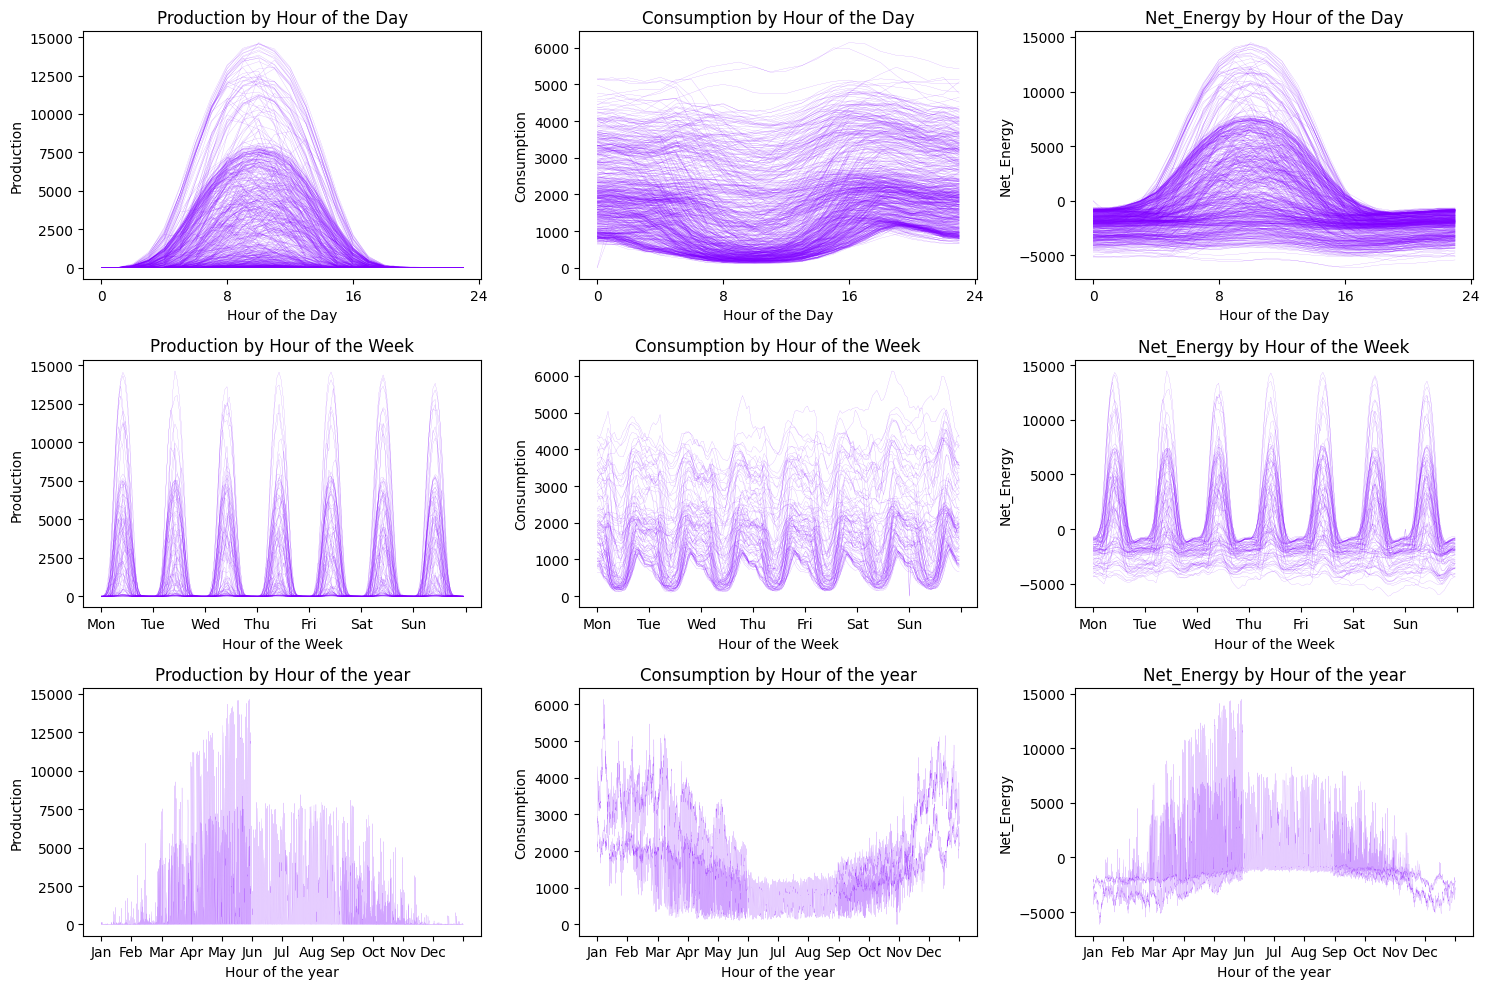

In [20]:
plot_seasonalities(energy, pool=0)

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 15px; border: 2px solid #f5ab64;\">
        <ul>
        <li> There are signs of daily and yearly seasonalities, slight increased variance over weekends but no clear sign of weekly seasonality. </li>
        <li> Most Pools had an increase variance in net energy over 2023, this is especially strong in Pool 0.</li>
</div>

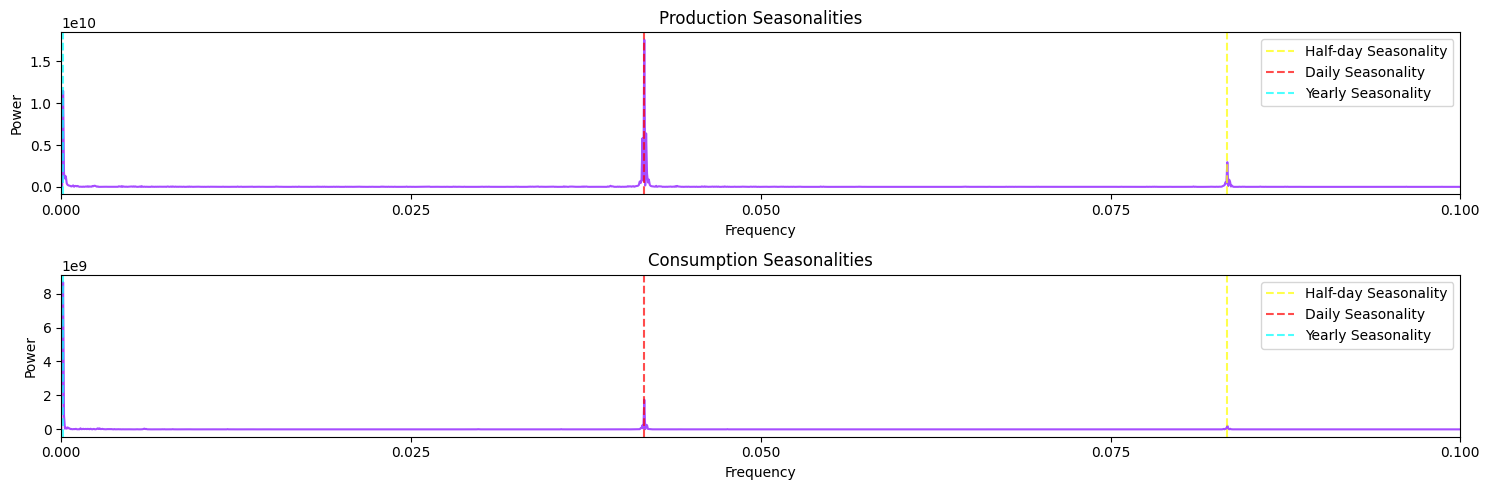

In [21]:
peridograms(energy, pool=0)

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 15px; border: 2px solid #f5ab64;\">
        <ul>
        <li> The peridograms validate the presence of strong daily and yearly seasonalities and highlight a half-day seasonality. </li>
        <li> Half-day seasonality in PV energy production likely due to the sun rising and setting, and to work schedules for energy consumption.  </li>
        <li> We'll assume the seasonalities observed are similar for all pools. </li>
</div>

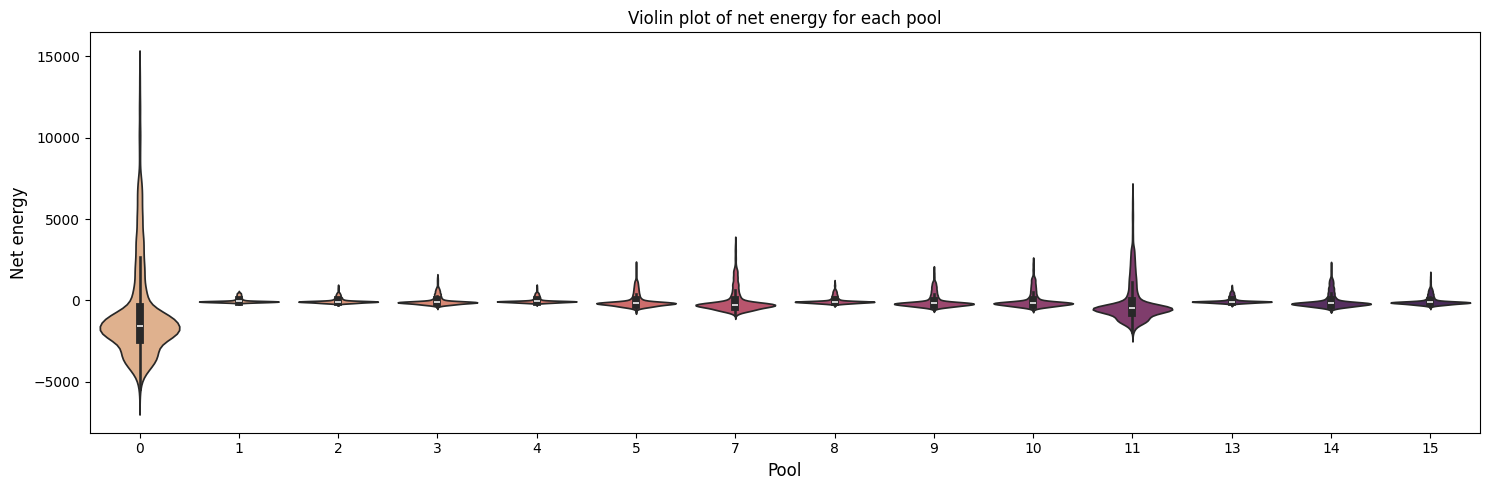

In [22]:
net_energy_violon_plot(energy)

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 15px; border: 2px solid #f5ab64;\">
        <ul>
        <li> Pool 0 and Pool 11 exhibit a different a different pattern compared to the other pools. </li>
        <li> Over the full time period studied, Pool 0 has much higher variance in its net energy compared to other pools, and has a mean energy consumption higher than its production. </li>
        <li> This suggest the net energy of Pool 0 and Pool 11 might be difficult to forecast with a single common model to all Pools. </li> 

</div>

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 10px; border: 2px solid #f5ab64;\">
    <h3> We'll now look at the weather data </h3>
</div>

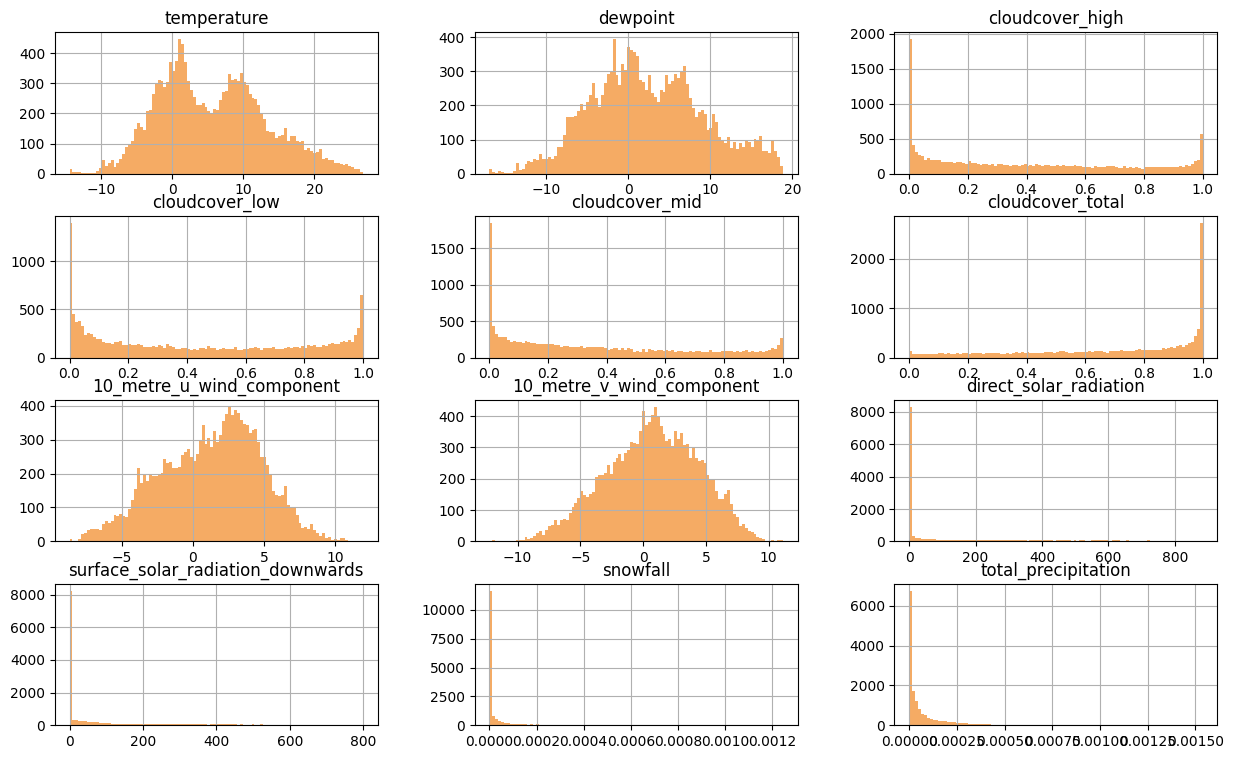

In [23]:
weather.loc[:,weather.columns != "datetime_utc"].hist(bins=100, figsize=(15,9),color="#f5ab64")
plt.show()

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 15px; border: 2px solid #f5ab64;\">
        <ul>
        <li> "temperature", "dewpoint", and wind components are approximatly normally distributed and centered around zero. </li>
        <li> Solar radiation, snowfall, and total_precipitation are heavily right skewed and contain outliers.  </li>
        <li> Cloud cover looks like u-shaped beta distribution.</li>
</div>

Let's Now Merge the Energy and Weather Data

In [24]:
df = energy.merge(weather, on="datetime_utc", how="left").copy()

Looking at Correlations between Non-Time Related Features

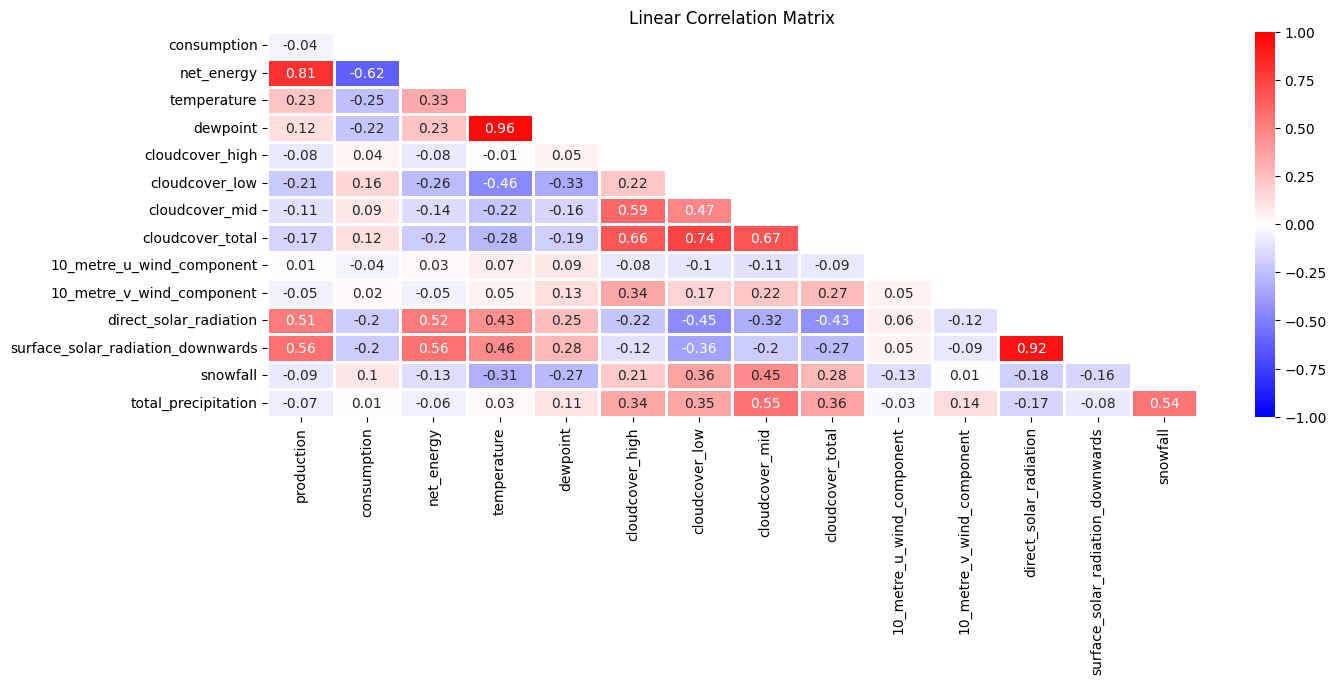

In [25]:
var_list = ['production', 'consumption', 'net_energy',  'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
correlation_matrix_plot(df[var_list])

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 15px; border: 2px solid #f5ab64;\">
        <ul>
        <li> Several variables exhibit strong positive correlations: (temperature and duepoint), (direct solar radiation and surface solar radiation), etc.  </li>
</div>

Looking at Autocorrelations of Net Energy Data

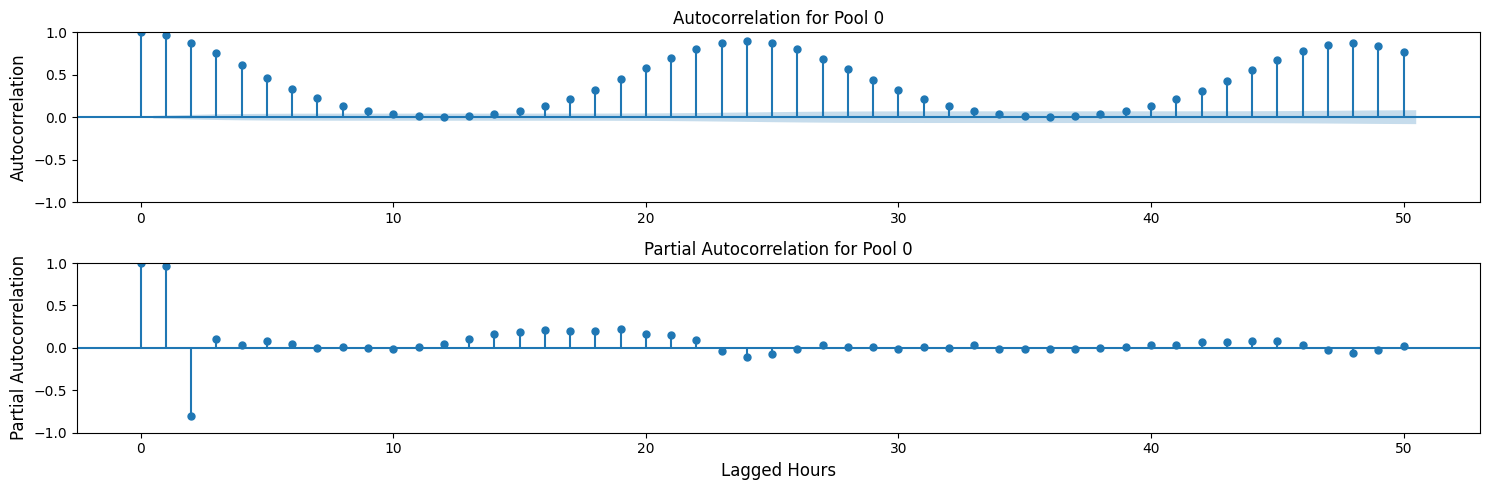

In [26]:
acf_and_pacf_plots(df, pool=0)

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 15px; border: 2px solid #f5ab64;\">
        <ul>
        <li> The autocorrelation plot shows strong daily seasonality. </li>
        <li> The partial autocorrelation plot suggests using 24h of lagged data for our prediction. </li>
</div>

<br><br><br>

<div style="background-color: #f5ab64; color: white; padding: 10px 20px 0px 20px; border-radius: 15px; font-size: 16px; border: 2px solid #f5ab64;">
    <h2>3 | Feature Engineering</h2>
    <h5>- Weather Variable Selection, Lagged Energy Data, Hot-One Encoding </h5>
</div>

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 10px; border: 2px solid #f5ab64;\">
    <h3> We'll add 24h lagged data to the energy dataset. </h3>
</div>

In [27]:
data = add_lag_columns_by_pool(df, lag=24)

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 10px; border: 2px solid #f5ab64;\">
    <h3> Energy production and comsumption must be dropped as we are predicting them indirectly through the net energy variable. </h3>
</div>

In [28]:
data.drop("production", axis=1, inplace=True)
data.drop("consumption", axis=1, inplace=True)

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 10px; border: 2px solid #f5ab64;\">
    <h3> Let's one-hot encode the non-ordinal categorical variables. </h3>
</div>

In [29]:
data = pd.get_dummies(data, columns=['pool'], dtype=int)            # pool column
data = pd.get_dummies(data, columns=["year_week"], dtype=int)       # year_week column

In [30]:
data.head()

,datetime_utc,net_energy,hour_of_day,day_of_week,hour_of_week,day_of_month,hour_of_year,day_of_year,week_of_year,month_of_year,...,year_week_2023-W20,year_week_2023-W21,year_week_2023-W22,year_week_2023-W3,year_week_2023-W4,year_week_2023-W5,year_week_2023-W6,year_week_2023-W7,year_week_2023-W8,year_week_2023-W9
0,2021-09-02 00:00:00,-809.801,0,3,72,2,5856,245,35,9,...,0,0,0,0,0,0,0,0,0,0
1,2021-09-02 01:00:00,-824.822,1,3,73,2,5857,245,35,9,...,0,0,0,0,0,0,0,0,0,0
2,2021-09-02 02:00:00,-801.711,2,3,74,2,5858,245,35,9,...,0,0,0,0,0,0,0,0,0,0
3,2021-09-02 03:00:00,-885.547,3,3,75,2,5859,245,35,9,...,0,0,0,0,0,0,0,0,0,0
4,2021-09-02 04:00:00,-625.983,4,3,76,2,5860,245,35,9,...,0,0,0,0,0,0,0,0,0,0


<br><br><br>

<div style="background-color: #f5ab64; color: white; padding: 10px 20px 0px 20px; border-radius: 15px; font-size: 16px; border: 2px solid #f5ab64;">
    <h2>5 | Model Fitting</h2>
    <h5>- XGBoost Forecasting </h5>
</div>

In [31]:
import xgboost as xgb

Setting up the XGBoost Model

In [32]:
xgb_clf = xgb.XGBRegressor( enable_categorical=False,           # Enable categorical "pool" features
                            objective = 'reg:absoluteerror',    # Objective function: MAE
                            early_stopping_rounds=50,          # Stop if no improvement for 100 rounds
                            eval_metric='mae',
                            n_estimators=300,                 # Maximum number of trees
                        )

Training the Model

In [33]:
train_xgb_forecast_model(data, xgb_clf)

[0]	validation_0-mae:314.18201	validation_1-mae:589.98613
[1]	validation_0-mae:278.38016	validation_1-mae:545.95287
[2]	validation_0-mae:244.43886	validation_1-mae:499.32302
[3]	validation_0-mae:214.00241	validation_1-mae:452.46802
[4]	validation_0-mae:187.41285	validation_1-mae:408.99352
[5]	validation_0-mae:158.68002	validation_1-mae:361.55997
[6]	validation_0-mae:131.97966	validation_1-mae:312.29952
[7]	validation_0-mae:109.78869	validation_1-mae:270.37335
[8]	validation_0-mae:96.56926	validation_1-mae:247.35979
[9]	validation_0-mae:85.56050	validation_1-mae:224.64403
[10]	validation_0-mae:76.54505	validation_1-mae:205.39930
[11]	validation_0-mae:68.88109	validation_1-mae:185.60259
[12]	validation_0-mae:63.25829	validation_1-mae:169.39979
[13]	validation_0-mae:58.49735	validation_1-mae:153.58974
[14]	validation_0-mae:55.40187	validation_1-mae:146.46514
[15]	validation_0-mae:53.38527	validation_1-mae:139.01018
[16]	validation_0-mae:51.69918	validation_1-mae:132.75209
[17]	validation_

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 10px; border: 2px solid #f5ab64;\">
    <h3> We'll now produce forecasts using our trained xgboost model. </h3>
</div>

Pool 1 Forecasts

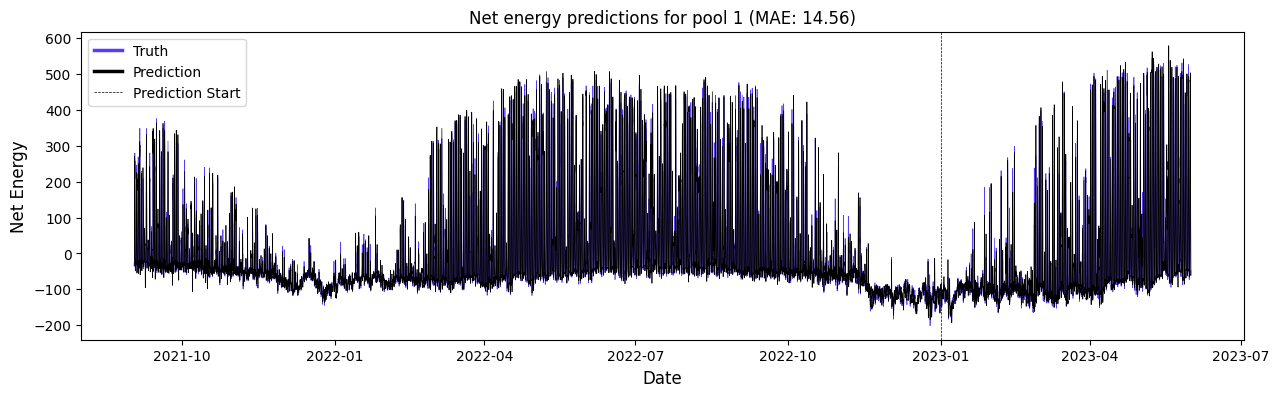

In [34]:
plot_pool_predictions(data, xgb_clf, pool=1)

Pool 13 Forecasts

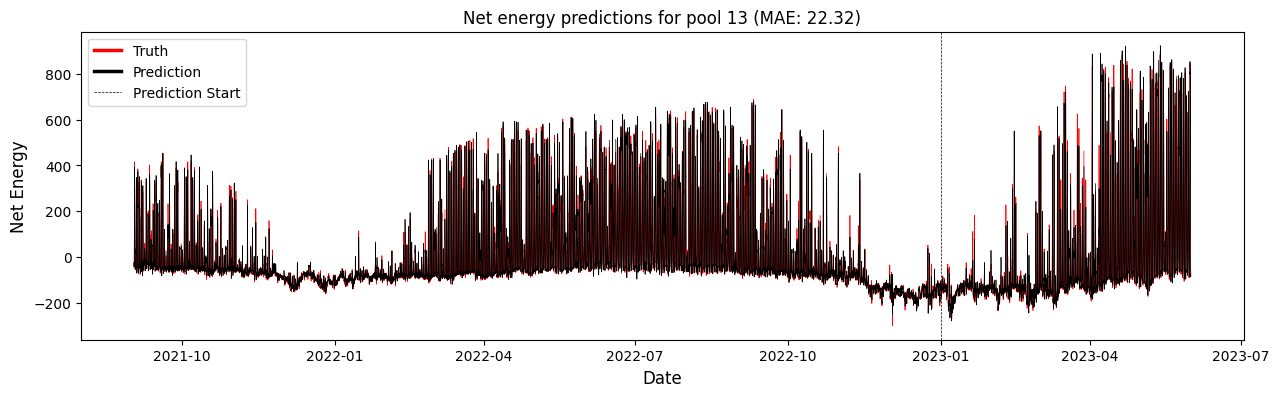

In [35]:
plot_pool_predictions(data, xgb_clf, pool=13)

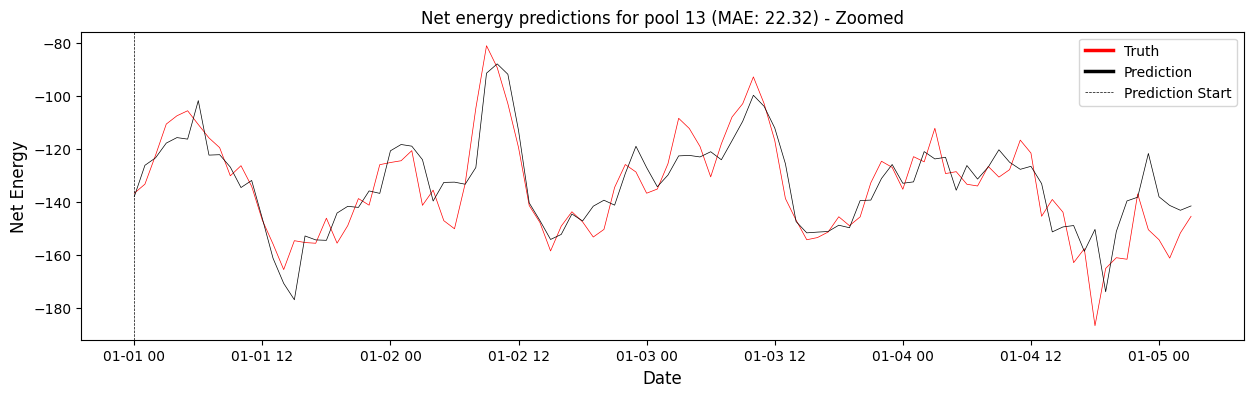

In [36]:
plot_pool_predictions(data, xgb_clf, pool=13, zoomed=True)

Forecast Performance Evaluation Over All Pools

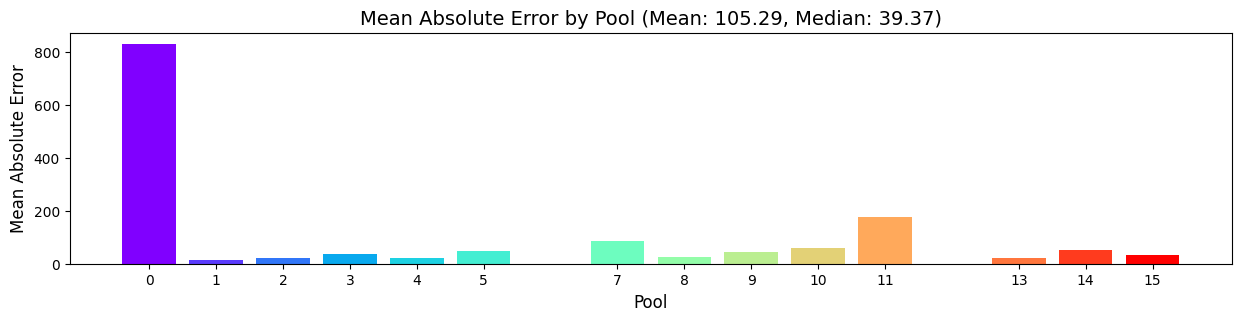

In [37]:
plot_all_mae(data, xgb_clf,df["pool"].unique())

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 10px; border-radius: 5px; font-size: 15px; border: 2px solid #f08721;\">
    <h4> Conclusion:  </h4>
    <ul>
        <li> Overall the XGBoost model performed well in forecasting the net energy for each pool with a median MAE of 39.4. </li>
        <li> One exception was Pool 0 which has a higher MAE (833.2) compared to the other pools. This aligns with the patterns observe during the exploratory data analysis which set it appart from the other pools. </li>
        <li> Forecasts for Pool 0 could be improved by using a different (e.g. LSTM) or hybrid model correcting the xgboost predictions. </li>
        <li> Our forecast accuracy is conditional on the weather forecast being accurate. </li>

</div>